In [0]:

import csv
import urllib.request as urllib2
import time
start_time = time.time()



import pandas as pd
 
#importing dataset in program
url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
response = urllib2.urlopen(url)

datap = pd.read_csv(response)
datap = datap.dropna()

In [2]:
# Answer 1

#getting first 10 values from datasets
datap.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


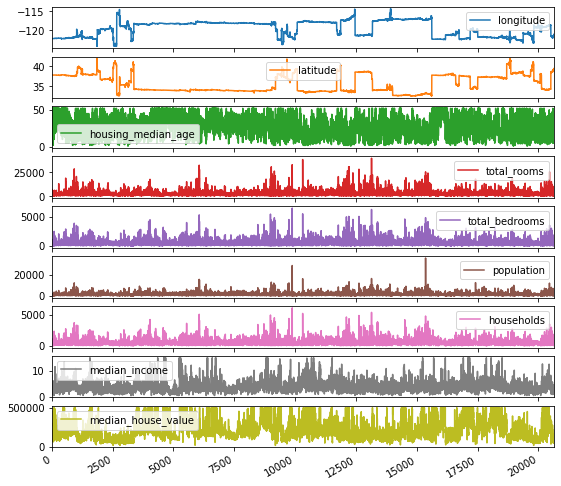

In [3]:
#plotting a line graph
datap.plot(subplots=True, figsize=(9, 9));

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import Dropout

from torch.nn import MaxPool1d
from torch.nn import AvgPool1d


from torch.nn import  Flatten

from torch.nn import Linear

from torch.nn.functional import relu

from torch.utils.data import DataLoader, TensorDataset

In [0]:
#subclass is defined
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    
    #defining each layers
    self.input_layer  = Conv1d(inputs, batch_size, 1)

    self.max_pooling_layer = MaxPool1d(1)
      
    self.conv_layer = Conv1d(batch_size, 256,1)
  
     #Conv1D
    
    self.flatten_layer = Flatten()

    self.linear_layer = Linear(256, 64)

    self.output_layer = Linear(64, outputs)
# method to get input for the model
  def feed(self,input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))

    output = self.max_pooling_layer(output)

    output = relu(self.conv_layer(output))

    output = self.flatten_layer(output)

    output = self.linear_layer(output)


    output = self.output_layer(output)

    return output

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
    
import numpy as np

In [7]:

datap_x = datap.loc[:,'longitude':'median_income']

#prdecting median house value on basis of remaining columns
datap_y = datap['median_house_value']

#splitting datasets for training and testing purpose
X_train, X_test, y_train, y_test = train_test_split(datap_x, datap_y, test_size=0.3, random_state=2003)

#converting testing datasets to numpy array
x_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

#converting training datasets to numpy array
x_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

print(x_train_np.shape, y_train_np.shape, x_test_np.shape, y_test_np.shape)

(14303, 8) (14303,) (6130, 8) (6130,)


In [8]:
#defining batch size
batch_size = 64

model = CnnRegressor(batch_size, datap_x.shape[1],1)

model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=256, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
from torch.optim import SGD
from torch.optim import Rprop
from torch.optim import Adadelta

from torch.nn import L1Loss
!pip install pytorch.ignite

from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 2.7MB/s 


In [0]:
#calculating average r^2 and average loss

def model_loss(model, dataa, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataa):
    # print("This is the shape ",input.shape)
    prediction = model.feed(input)

    loss = performance(prediction, output)

    score_metric.update([prediction, output])
    score = score_metric.compute()

    if (train):
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count += 1
 
  return avg_loss / count, avg_score / count

In [11]:
#creating a loader and training the loop using epochs

epochs = 500

#optimizer = Rprop(model.parameters())
optimizer = Adadelta(model.parameters(),lr=1.0,rho=0.4,eps=1e-06,weight_decay=0)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)
xx = 0
yy = 0
for epoch in range(epochs):
  avg_loss, avg_2_score = model_loss(model, loader, train = True, optimizer = optimizer)
  if avg_2_score > xx:
    xx = avg_2_score
    yy = epochs 


print("Epoch ",str(epoch+1)," Loss", str(avg_loss), " R2Score",str(avg_2_score))

Epoch  500  Loss 51821.78347463565  R2Score 0.6221784965882202


In [12]:

#creating a loader to work with our batches

inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)

loader = DataLoader(tensor,batch_size, shuffle=True, drop_last=True)


avg_loss, avg_r2_score = model_loss(model, loader)

print("Loss = " + str(avg_loss) + "\nR^2 Score = " + str(avg_r2_score))
print("--- %s seconds ---" % (time.time() - start_time))



Loss = 51477.94995888158
R^2 Score = 0.594063882931122
--- 356.797709941864 seconds ---
